# Exploration of the .skeleton files provided in the NTU-RGB-D dataset

S : setup number 
C : camera id
P : performer id
R : replication number
A : action label

In [1]:
import numpy as np
import os
from joints import *
from utils import *
import random

import ffmpeg
from matplotlib import animation
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

ntu_path = "/media/gnocchi/Toshiba Ext/NTU-RGB-D/"

rgb_folder = "nturgb+d_rgb/"
skeleton_folder = "nturgb+d_skeletons/"

sample_name = os.path.splitext(random.choice(os.listdir(ntu_path + skeleton_folder)))[0]
print(sample_name)
# sample_name = "S016C003P008R002A059"
# sample_name = "S001C001P001R001A001"
sample_name = "S002C003P007R001A060"

S012C001P027R001A012


## Skeleton numpy array

read_xyz(...) returns a (3, max_frame, num_joint=25, 2) numpy array

read_color_xy(...) returns (2, max_frame, num_joint=25, 2) numpy array

In [2]:
skeleton = read_xyz(ntu_path + skeleton_folder + sample_name + ".skeleton") # shape (3, 103, 25, 2)

print("===== 3D skeleton =====")
print(skeleton[:, 0, :, 0])
print(skeleton.transpose(3, 2, 0, 1)[0].shape)

print("\r\n===== 2D RGB skeleton =====")
skeleton_2d = read_color_xy(ntu_path + skeleton_folder + sample_name + ".skeleton")
print(skeleton_2d[:, 0, :, 0])

has_2_subjects = np.any(skeleton_2d[:, :, :, 1])
print("Number of subjects : " + str(int(has_2_subjects) * 2))

===== 3D skeleton =====
[[-0.394 -0.405 -0.414 -0.373 -0.474 -0.51  -0.449 -0.433 -0.352 -0.32
  -0.293 -0.296 -0.416 -0.476 -0.539 -0.503 -0.358 -0.358 -0.398 -0.293
  -0.412 -0.398 -0.492 -0.289 -0.27 ]
 [-0.166  0.149  0.452  0.574  0.3    0.061 -0.169 -0.249  0.386  0.136
  -0.1   -0.161 -0.179 -0.523 -0.899 -0.967 -0.147 -0.544 -0.865 -0.913
   0.378 -0.314 -0.231 -0.233 -0.172]
 [ 2.304  2.185  2.05   2.048  1.954  1.95   2.01   2.05   2.232  2.333
   2.435  2.442  2.205  2.286  2.43   2.447  2.323  2.448  2.555  2.491
   2.087  2.078  2.086  2.456  2.439]]
(25, 3, 64)

===== 2D RGB skeleton =====
[[797.7908 783.1007 766.57   787.1985 724.8397 705.205  745.5892 758.064
  811.4343 832.9348 850.0088 849.1721 779.8076 758.921  742.91   760.3863
  815.4762 822.9352 812.3044 853.5698 770.8203 778.6304 731.2129 852.8409
  860.1266]
 [616.1281 467.8019 305.9812 241.7928 376.8837 506.8248 629.3143 668.9015
  356.0623 478.055  583.1234 609.4161 626.1128 782.9975 933.2611 960.2062
  606.76

## Skeleton animation

In [3]:
%matplotlib notebook
import matplotlib.pyplot as plt
import time
import mpl_toolkits.mplot3d as plt3d

def animateJointCoordinates(joint_coordinates, connexion_tuples):
    '''
    joint_coordinates : shape(joints, 3, seq_len)
    
    
    '''
    fig = plt.figure()
    fig.set_size_inches(10,10)
    ax = plt.axes(projection='3d')
    
    plt.ion()
    fig.show()
    fig.canvas.draw()
    
    x = 0
    y = 2
    z = 1

    
    for t in range(joint_coordinates.shape[2]):
        ax.clear()
        ax.set_xlim3d(np.amin(joint_coordinates[:, x, :]), np.amax(joint_coordinates[:, x, :]))
        ax.set_ylim3d(np.amin(joint_coordinates[:, y, :]), np.amax(joint_coordinates[:, y, :]))
        ax.set_zlim3d(np.amin(joint_coordinates[:, z, :]), np.amax(joint_coordinates[:, z, :]))
        
        ax.scatter(joint_coordinates[:, x, t], joint_coordinates[:, y, t], joint_coordinates[:, z, t])
        
        
        line = plt3d.art3d.Line3D([0.1, 0.1], [0.1, 0.5], [0.1, 0.1])
        
        head_neck = plt3d.art3d.Line3D([joint_coordinates[0, x, t], joint_coordinates[1, x, t]], 
                                      [joint_coordinates[0, y, t], joint_coordinates[1, y, t]], 
                                      [joint_coordinates[0, z, t], joint_coordinates[1, z, t]])
        
        # ax.add_line(head_neck)
        
        for i in range(connexion_tuples.shape[0]):
            j1 = connexion_tuples[i, 0]
            j2 = connexion_tuples[i, 1]
            
            
            joint_line = plt3d.art3d.Line3D([joint_coordinates[j1, x, t], joint_coordinates[j2, x, t]], 
                                            [joint_coordinates[j1, y, t], joint_coordinates[j2, y, t]], 
                                            [joint_coordinates[j1, z, t], joint_coordinates[j2, z, t]])
            
            ax.add_line(joint_line)
        
        ax.view_init(10, 10)
        
        fig.canvas.draw()
        plt.pause(.001)
        # time.sleep(0.01)

In [4]:
# animateJointCoordinates(skeleton.transpose(3, 2, 0, 1)[0], connexion_tuples)

## Video playback with hand tracking for 1 or 2 subjects

Creates a video object of size (seq_len, 1080, 1920, 3)

In [5]:
probe = ffmpeg.probe(ntu_path + rgb_folder + sample_name + '_rgb.avi')
video_info = next(x for x in probe['streams'] if x['codec_type'] == 'video')
width = int(video_info['width'])
height = int(video_info['height'])
num_frames = int(video_info['nb_frames'])
print(num_frames)

64


In [6]:
out, err = (ffmpeg
           .input(ntu_path + rgb_folder + sample_name + '_rgb.avi')
           .output('pipe:', format='rawvideo', pix_fmt='rgb24')
           .run(capture_stdout=True)
)
video = np.frombuffer(out, np.uint8).reshape([-1, height, width, 3])
print(video.shape)

(64, 1080, 1920, 3)


<IPython.core.display.Javascript object>


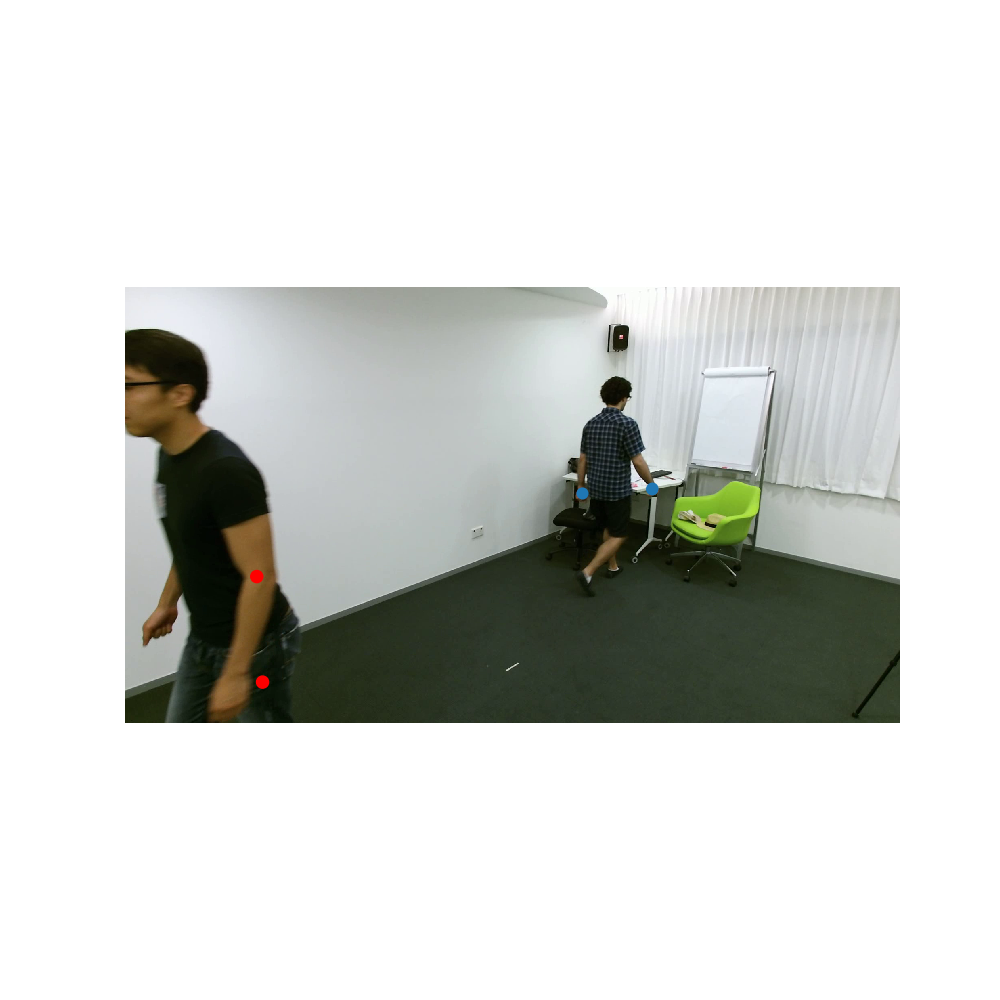

In [9]:
f = plt.figure()
ax = f.gca()
f.set_size_inches(10,10)

image = plt.imshow(video[0], interpolation='None', animated = True)

# skeleton_2d shape (2{xy}, max_frame, num_joint=25, 2)
right_hand_s1 = Circle((skeleton_2d[0, 0, Joints.HANDRIGHT, 0], skeleton_2d[1, 0, Joints.HANDRIGHT, 0]),15, color="red")
left_hand_s1 = Circle((skeleton_2d[0, 0, Joints.HANDLEFT, 0], skeleton_2d[1, 0, Joints.HANDLEFT, 0]),15, color="red")

ax.add_patch(right_hand_s1)
ax.add_patch(left_hand_s1)

if has_2_subjects:
    right_hand_s2 = Circle((skeleton_2d[0, 0, Joints.HANDRIGHT, 1], skeleton_2d[1, 0, Joints.HANDRIGHT, 1]),15)
    left_hand_s2 = Circle((skeleton_2d[0, 0, Joints.HANDLEFT, 1], skeleton_2d[1, 0, Joints.HANDLEFT, 1]),15)
    
    ax.add_patch(right_hand_s2)
    ax.add_patch(left_hand_s2)



plt.axis('off')


def videoAnimation(frame_index):
    image.set_data(video[frame_index])
    [p.remove() for p in ax.patches]
    right_hand_s1 = Circle((skeleton_2d[0, frame_index, Joints.HANDRIGHT, 0], skeleton_2d[1, frame_index, Joints.HANDRIGHT, 0]),15, color='red')
    left_hand_s1 = Circle((skeleton_2d[0, frame_index, Joints.HANDLEFT, 0], skeleton_2d[1, frame_index, Joints.HANDLEFT, 0]),15, color='red')
    
    ax.add_patch(right_hand_s1)
    ax.add_patch(left_hand_s1)
    
    if has_2_subjects:
        right_hand_s2 = Circle((skeleton_2d[0, frame_index, Joints.HANDRIGHT, 1], skeleton_2d[1, frame_index, Joints.HANDRIGHT, 1]),15)
        left_hand_s2 = Circle((skeleton_2d[0, frame_index, Joints.HANDLEFT, 1], skeleton_2d[1, frame_index, Joints.HANDLEFT, 1]),15)

        ax.add_patch(right_hand_s2)
        ax.add_patch(left_hand_s2)
    
    return image,

ani = animation.FuncAnimation(f, videoAnimation, interval = 200, frames = num_frames, repeat = False)


## Crop around the hands

According to "Pose-conditioned Spatio-Temporal Attention for Human Action Recognition" https://arxiv.org/pdf/1703.10106.pdf, the crops are 50x50p around hands on NTU dataset. The same cropping dimensions are kept on latter paper STA-Hands by same author.


In [8]:
hand_crops = extract_hands(skeleton_2d, video, crop_size) # shape (n_frames, 4, crop_size, crop_size, 3)
if hand_crops.shape[1] == 2:
    pad = np.zeros(hand_crops.shape, dtype=hand_crops.dtype)
    hand_crops = np.concatenate((hand_crops, pad), axis = 1)


ValueError: could not broadcast input array from shape (0,50,3) into shape (50,50,3)

In [ ]:
# Using video for variable from above of shape (seq_len, 1080, 1920, 3)
f, (axs) = plt.subplots(2, 2)
f.set_size_inches(8, 8)
axs[0, 0].axis('off')
axs[0, 1].axis('off')
axs[1, 0].axis('off')
axs[1, 1].axis('off')

s1_l = axs[0, 0].imshow(hand_crops[0, 0])
s1_r = axs[0, 1].imshow(hand_crops[0, 1])
s2_l = axs[1, 0].imshow(hand_crops[0, 2])
s2_r = axs[1, 1].imshow(hand_crops[0, 3])


def videoAnimation(frame_index):
    s1_l.set_data(hand_crops[frame_index, 0])
    s1_r.set_data(hand_crops[frame_index, 1])
    s2_l.set_data(hand_crops[frame_index, 2])
    s2_r.set_data(hand_crops[frame_index, 3])
    
    axs[0, 0].set_title(frame_index)
    axs[0, 1].set_title(frame_index)
    axs[1, 0].set_title(frame_index)
    axs[1, 1].set_title(frame_index)
    
    
    return s1_l

ani = animation.FuncAnimation(f, videoAnimation, interval = 200, frames = num_frames, repeat = False)